In [1]:
import torch
import matplotlib.pyplot as plt
from utils import *



"""window_size = 7
Window =  get_gaussian_kernel2d((window_size, window_size), (1.5, 1.5))
print(Window)


model = AE_small5()

PATH = "./Data_aug/AE_small5_model.pth"
model.load_state_dict(torch.load(PATH))


SIZE = 1000
BATCH_SIZE = 1

test_set = Dataset(SIZE, train = False)
loader_1 = torch.utils.data.DataLoader(dataset = test_set,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False)
#number of images to plot


PSNR = torch.empty(size = (1, SIZE))
SSIM_results = torch.empty(size = (1, SIZE))
i = 0
for noisy_imgs, ground_truth in loader_1:
    denoised = model(noisy_imgs)
    PSNR[0, i] = psnr(denoised/255, ground_truth/255)
    SSIM_results[0, i] = 1-ssim(ground_truth/255, denoised/255)
    i += 1
print("Model PSNR:", torch.mean(PSNR).item()) #display the mean of PSNR over the test set.
print("Model SSIM:", torch.mean(SSIM_results).item()) #display the mean of PSNR over the test set.

plt.imshow(torch.squeeze(denoised).permute(1, 2, 0).int())
plt.show()"""


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, SIZE, train = True, transform = None, switch_pixels = None):
        'Initialization'
        if train: 
            if SIZE > 50000: 
                print("SIZE is to big. It is set to SIZE = 50000.")
                SIZE = 50000
            x, y = torch.load("train_data.pkl")
            print("Training data : \n noisy_imgs_1 : ", x.shape, "\n noisy_imgs_2 : ", y.shape)
        else : 
            if SIZE > 1000:
                print("SIZE is to big. It is set to SIZE = 1000.")
                SIZE = 1000
            x, y = torch.load("val_data.pkl")
            print("Test data : \n noisy_imgs : ", x.shape, "\n clean_imgs : ", y.shape)
        x, y = x[:SIZE], y[:SIZE]
        print("Data reduced : \n noisy_imgs_1_reduced : ", x.shape, "\n noisy_imgs_2_reduced : ", y.shape)
        print("Type : ", x.dtype)
        if transform != None :
            print("With data augmentation : transform.")
        if switch_pixels != None :
            print("With data augmentation : switch pixels with n_max = ", switch_pixels[0], " and p = ", switch_pixels[1])
        self.x = x.float()
        self.y = y.float()
        self.transform = transform
        self.switch_pixels = switch_pixels

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # get label
        X_trans = self.x[index]
        Y_trans= self.y[index]

        seed = torch.randint(2147483647,(1,1)) # make a seed with generator 
        torch.manual_seed(seed.item()) # set the random seed for transforms
        if self.transform is not None:
            X_trans = self.transform(X_trans)

        torch.manual_seed(seed.item()) # set the random seed for transforms
        if self.transform is not None:
            Y_trans = self.transform(Y_trans)  
        
        torch.manual_seed(seed.item())
        if self.switch_pixels is not None:
            n_max, p = self.switch_pixels
            # n_max : maximum number of pixels that might switch. 
            # p : prob that the pixels are switched.
            if torch.rand((1,1)) < p:
                if n_max<50 :
                    n_max = 51
                # n : number of switched pixels, random in between 50 and n_max (not included)
                n = torch.randint(low = 50, high = n_max, size = (1,1))
                # index : random index of the n pixels that will be switched.
                index = torch.randint(low=0, high = X_trans.shape[1], size = (n,2))
                i,j = index[:, 0], index[:, 1]
                v_x = Y_trans[:, i, j]
                v_y = X_trans[:, i, j]

                X_trans[:, i, j] = v_x
                Y_trans[:, i, j] = v_y

        return X_trans, Y_trans

cpu


Training data : 
 noisy_imgs_1 :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2 :  torch.Size([50000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([50000, 3, 32, 32])
Type :  torch.uint8
Training with new loss : 
epoch :  0
epoch :  1
epoch :  2
epoch :  3
epoch :  4
epoch :  5
epoch :  6
epoch :  7
epoch :  8
epoch :  9


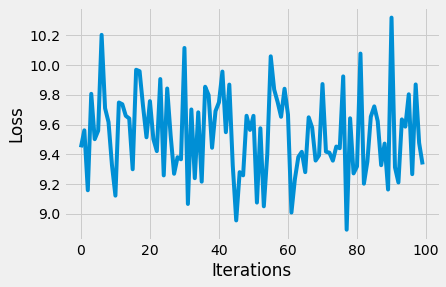

In [2]:
"""
We study the new loss given by SSIM.
"""

SIZE = 50000
BATCH_SIZE = 128
train_set = Dataset(SIZE)


# Model Initialization
model_SSIM = AE_small5()
model = AE_small5()
alpha = 0.5

# Validation using Loss functions
loss_function_huber = nn.HuberLoss()
loss_function_SSIM = SSIM()
  
# Using an Adam Optimizer with lr = 0.001
optimizer_SSIM = torch.optim.Adam(model_SSIM.parameters(),
                             lr = 1e-3, betas=(0.9, 0.99))      
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3, betas=(0.9, 0.99))                      

# DataLoader is used to load the dataset 
# for training
loader_1 = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)                                 

#OPTIMIZATION
epochs = 10
outputs = []
losses = []
print("Training with new loss : ")
for epoch in range(epochs):
    print("epoch : ", epoch)
    for noisy_imgs_1, noisy_imgs_2 in loader_1:
        # Output of Autoencoder
        #print("type : ", noisy_imgs_1.dtype)
        noisy_imgs_1 = noisy_imgs_1.to(device)
        noisy_imgs_2 = noisy_imgs_2.to(device)
        reconstructed = model_SSIM(noisy_imgs_1)
            
        # Calculating the loss function
        loss = (1-alpha)*loss_function_huber(reconstructed, noisy_imgs_2) + alpha*loss_function_SSIM(reconstructed, noisy_imgs_2)
            
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer_SSIM.zero_grad()
        loss.backward()
        optimizer_SSIM.step()
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
    outputs.append((epochs, noisy_imgs_2, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.savefig("./Data_aug/AE_small5_new_loss_losses")
plt.show()

PATH = "./Data_aug/AE_small5_model_new_loss.pth"
torch.save(model_SSIM.state_dict(), PATH)


In [ ]:
#OPTIMIZATION WITH HUBER LOSS ONLY
epochs = 10
outputs = []
losses = []
print("Training with Huber loss only : ")
for epoch in range(epochs):
    print("epoch : ", epoch)
    for noisy_imgs_1, noisy_imgs_2 in loader_1:
        # Output of Autoencoder
        #print("type : ", noisy_imgs_1.dtype)
        noisy_imgs_1 = noisy_imgs_1.to(device)
        noisy_imgs_2 = noisy_imgs_2.to(device)
        reconstructed = model(noisy_imgs_1)
            
        # Calculating the loss function
        loss = loss_function_huber(reconstructed, noisy_imgs_2)
            
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
    outputs.append((epochs, noisy_imgs_2, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.savefig("./Data_aug/AE_small5_huber_loss_losses")
plt.show()

PATH = "./Data_aug/AE_small5_model_huber_loss.pth"
torch.save(model.state_dict(), PATH)

size :  1000
Test data : 
 noisy_imgs :  torch.Size([1000, 3, 32, 32]) 
 clean_imgs :  torch.Size([1000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([1000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([1000, 3, 32, 32])
Type :  torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model  0  PSNR: 24.585771560668945
Model  0  SSIM: 0.8189544081687927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model  1  PSNR: 24.576616287231445
Model  1  SSIM: 0.8237040638923645


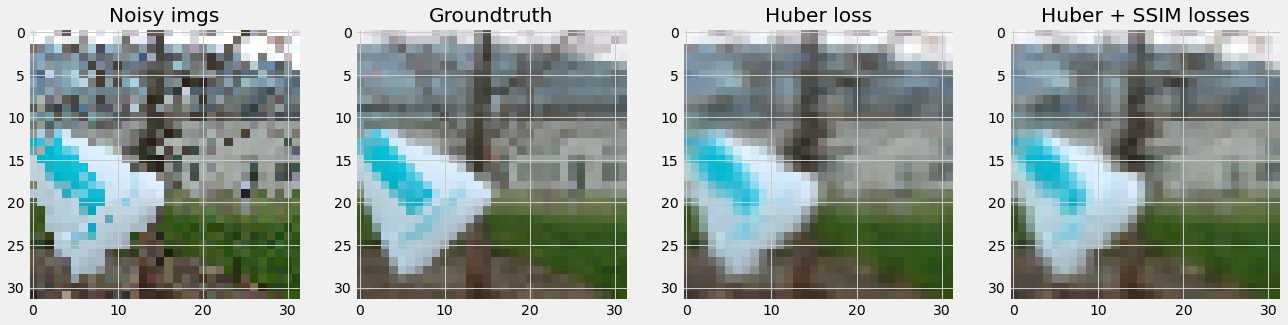

In [3]:
model_huber = AE_small5()
PATH_HUBER = "./Data_aug/AE_small5_model_huber_loss.pth"
model_huber.load_state_dict(torch.load(PATH_HUBER))

model_SSIM = AE_small5()
PATH_SSIM = "./Data_aug/AE_small5_model_new_loss.pth"
model_SSIM.load_state_dict(torch.load(PATH_SSIM))


PATHS = [PATH_HUBER, PATH_SSIM] 
models = [model_huber, model_SSIM]
names = ["Huber loss", "Huber + SSIM losses"]
plt.figure(figsize=(20, 10))
compare_models(PATHS, models, names)

Training data : 
 noisy_imgs_1 :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2 :  torch.Size([50000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([50000, 3, 32, 32])
Type :  torch.uint8
Training with new loss : 
epoch :  0
epoch :  1
epoch :  2
epoch :  3
epoch :  4
epoch :  5
epoch :  6
epoch :  7
epoch :  8
epoch :  9


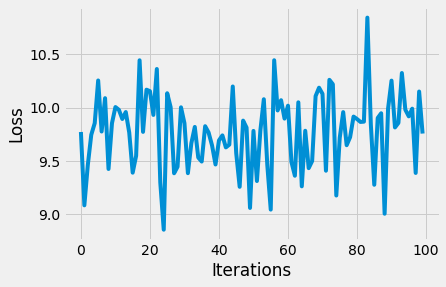

In [4]:
"""
We study the new loss given by SSIM. L1 + SSIM
"""
SIZE = 50000
train_set = Dataset(SIZE)
# Model Initialization
model_SSIM = AE_small5()
alpha = 0.5

# Validation using Loss functions
loss_function_l1 = nn.L1Loss()
loss_function_SSIM = SSIM()
  
# Using an Adam Optimizer with lr = 0.001
optimizer_SSIM = torch.optim.Adam(model_SSIM.parameters(),
                             lr = 1e-3, betas=(0.9, 0.99))      
                     

# DataLoader is used to load the dataset 
# for training
loader_1 = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)                                 

#OPTIMIZATION
epochs = 10
outputs = []
losses = []
print("Training with new loss : ")
for epoch in range(epochs):
    print("epoch : ", epoch)
    for noisy_imgs_1, noisy_imgs_2 in loader_1:
        # Output of Autoencoder
        #print("type : ", noisy_imgs_1.dtype)
        noisy_imgs_1 = noisy_imgs_1.to(device)
        noisy_imgs_2 = noisy_imgs_2.to(device)
        reconstructed = model_SSIM(noisy_imgs_1)
            
        # Calculating the loss function
        loss = (1-alpha)*loss_function_l1(reconstructed, noisy_imgs_2) + alpha*loss_function_SSIM(reconstructed, noisy_imgs_2)
            
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer_SSIM.zero_grad()
        loss.backward()
        optimizer_SSIM.step()
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
    outputs.append((epochs, noisy_imgs_2, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.savefig("./Data_aug/AE_small5_new_loss_l1_losses")
plt.show()

PATH = "./Data_aug/AE_small5_model_new_loss_l1.pth"
torch.save(model_SSIM.state_dict(), PATH)

In [ ]:
#OPTIMIZATION WITH L1 LOSS ONLY
model = AE_small5()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3, betas=(0.9, 0.99)) 
epochs = 10
outputs = []
losses = []
print("Training with L1 loss only : ")
for epoch in range(epochs):
    print("epoch : ", epoch)
    for noisy_imgs_1, noisy_imgs_2 in loader_1:
        # Output of Autoencoder
        #print("type : ", noisy_imgs_1.dtype)
        noisy_imgs_1 = noisy_imgs_1.to(device)
        noisy_imgs_2 = noisy_imgs_2.to(device)
        reconstructed = model(noisy_imgs_1)
            
        # Calculating the loss function
        loss = loss_function_l1(reconstructed, noisy_imgs_2)
            
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
    outputs.append((epochs, noisy_imgs_2, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.savefig("./Data_aug/AE_small5_l1_loss_losses")
plt.show()

PATH = "./Data_aug/AE_small5_model_l1_loss.pth"
torch.save(model.state_dict(), PATH)

size :  1000
Test data : 
 noisy_imgs :  torch.Size([1000, 3, 32, 32]) 
 clean_imgs :  torch.Size([1000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([1000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([1000, 3, 32, 32])
Type :  torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model  0  PSNR: 24.585771560668945
Model  0  SSIM: 0.8189544081687927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model  1  PSNR: 24.576616287231445
Model  1  SSIM: 0.8237040638923645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model  2  PSNR: 24.358036041259766
Model  2  SSIM: 0.8181870579719543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model  3  PSNR: 24.597248077392578
Model  3  SSIM: 0.8208701610565186


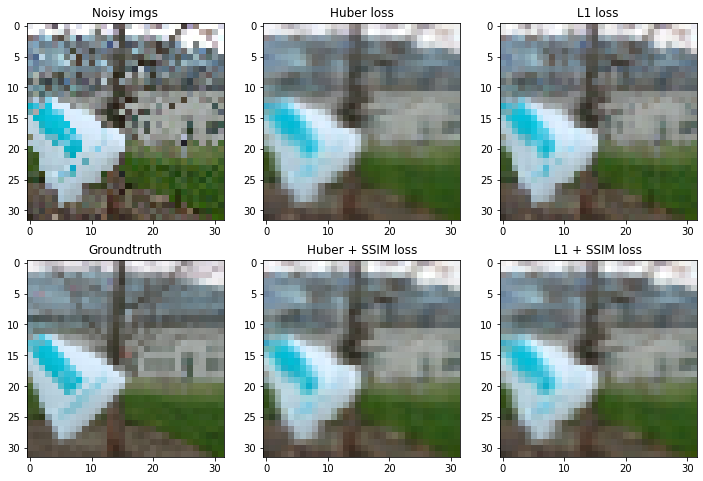

In [6]:
model_huber = AE_small5()
PATH_HUBER = "./Data_aug/AE_small5_model_huber_loss.pth"
model_huber.load_state_dict(torch.load(PATH_HUBER))

model_SSIM = AE_small5()
PATH_SSIM = "./Data_aug/AE_small5_model_new_loss.pth"
model_SSIM.load_state_dict(torch.load(PATH_SSIM))

model_l1 = AE_small5()
PATH_L1 = "./Data_aug/AE_small5_model_l1_loss.pth"
model_l1.load_state_dict(torch.load(PATH_L1))

model_l1_SSIM = AE_small5()
PATH_L1_SSIM = "./Data_aug/AE_small5_model_new_loss_l1.pth"
model_l1_SSIM.load_state_dict(torch.load(PATH_L1_SSIM))

PATHS = [PATH_HUBER, PATH_SSIM, PATH_L1, PATH_L1_SSIM] 
models = [model_huber, model_SSIM, model_l1, model_l1_SSIM]
names = ["Huber loss", "Huber + SSIM loss", "L1 loss", "L1 + SSIM loss"]

compare_models(PATHS, models, names)